In [1]:
%load_ext autoreload

import random as r
import json

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from AbstractArchitecture import AbstractArchitecture
from DenseEncoder import DenseEncoder
from DenseDecoder import DenseDecoder
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from plot_model_prediction import plot_model_prediction

In [2]:
# Set Experiment Specifics
expt_name = "Experiment_01"
data_file_prefix = './data/NLSL_expt1'  ## FILL IN HERE (from file name)

# Network architecture design
l = 20  # Latent space size

activation = "relu"
initializer = tf.keras.initializers.VarianceScaling()
reg_lambda_l2 = 1e-6
regularizer = tf.keras.regularizers.l2(reg_lambda_l2)

act_layer = dict(activation=activation,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
lin_layer = dict(activation=None,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
# For experiment 00 and 02:
#latent_config = dict(activation=None, 
#                     kernel_regularizer=regularizer,
#                     use_bias=False)
# For experiment 01:
latent_config = dict(activation=None)

encoder_layers = 3
decoder_layers = 4
add_identity = True

# Model training settings
## Set optimizer
optimizer = keras.optimizers.Adam
optimizer_opts = {}

# Callback function(s) and fit method options
cbs = [keras.callbacks.EarlyStopping(patience=10)]

# Batch size for model training
batch_size = 64


############################################
### Reconstruct the appropriate model ###
############################################
## Set the model weight paths:
model_weight_path = "./data/{}_final_model_weights.tf".format(expt_name)

# Step 1. Load in the data
data_train_u = np.load("{}_train1_u.npy".format(data_file_prefix))
data_train_f = np.load("{}_train1_f.npy".format(data_file_prefix))
data_val_u = np.load("{}_val_u.npy".format(data_file_prefix))
data_val_f = np.load("{}_val_f.npy".format(data_file_prefix))
data_test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix))
data_test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix))
data_test_u = np.load("{}_test2_u.npy".format(data_file_prefix))
data_test_f = np.load("{}_test2_f.npy".format(data_file_prefix))

# Step 2. Set up the model architecture
_, n = data_train_u.shape

encoder_config = {'units_full': n,
                  'num_layers': encoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

decoder_config = {'units_full': n,
                  'num_layers': decoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

# Aggregate settings for model architecture
architecture_config = {"units_latent": l,
                       "u_encoder_block": DenseEncoder(**encoder_config),
                       "u_decoder_block": DenseDecoder(**decoder_config),
                       "F_encoder_block": DenseEncoder(**encoder_config),
                       "F_decoder_block": DenseDecoder(**decoder_config),
                       "latent_config": latent_config}



## Step 5. Set up the full architecture run!!

# Set up validation data, loss functions, and number of epochs
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f, data_val_u)]
loss_fns = 4*[NMSE()]

# Instantiate the new model
full_model = AbstractArchitecture(**architecture_config,
                                  train_autoencoders_only=False)


# Load the weights
full_model.load_weights(model_weight_path)
#full_model.compile(loss=loss_fns, optimizer=optimizer())


In [3]:
u_aec, f_aec, f_pred, u_pred = full_model.predict(x=[data_val_u, data_val_f])

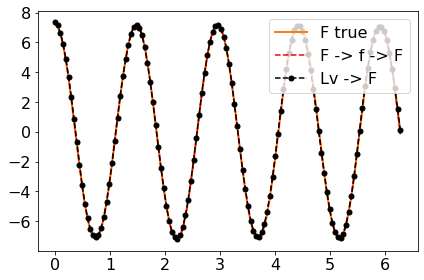

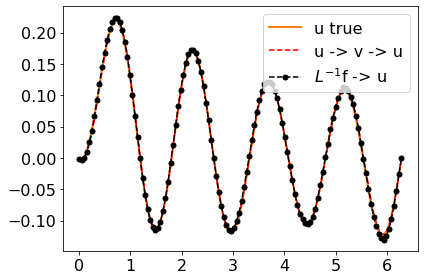

In [11]:
plot_model_prediction(full_model, 7, data_val_u, data_val_f)

In [5]:
def calculate_loss(exact,pred,denominator_nonzero=0,rel_loss=1):

    if rel_loss:
        loss_denominator = tf.reduce_mean(tf.square(exact),1) + denominator_nonzero
    else:
        loss_denominator = tf.to_double(1.0)
    norm_squared = tf.reduce_mean(tf.square(exact - pred), 1)
    rel_error = tf.truediv(norm_squared, loss_denominator)
    mse = tf.reduce_mean(rel_error)
    return mse
    


In [6]:
# Prepare a loss function object for TF2 losses
nmse = NMSE()

In [7]:
tf1_losses = {}
tf2_losses = {}
diff = {}

tf1_fn = lambda true, pred: calculate_loss(true, pred, denominator_nonzero=10**-5)
tf2_fn = nmse

losses = {"u_aec": [data_val_u, u_aec],
          "f_aec": [data_val_f, f_aec],
          "Lv_dec": [data_val_f, f_pred],
          "Linvf_dec": [data_val_u, u_pred]}

for key in list(losses):
    tf1 = tf1_fn(*losses[key])
    tf2 = tf2_fn(*losses[key])

    tf1_losses[key] = tf1
    tf2_losses[key] = tf2
    diff[key] = tf2-tf1


In [8]:
tf1_losses

{'u_aec': <tf.Tensor: shape=(), dtype=float64, numpy=0.001676292567984338>,
 'f_aec': <tf.Tensor: shape=(), dtype=float64, numpy=0.008741188048222956>,
 'Lv_dec': <tf.Tensor: shape=(), dtype=float64, numpy=0.01782200011439166>,
 'Linvf_dec': <tf.Tensor: shape=(), dtype=float64, numpy=0.015942749667902587>}

In [9]:
tf2_losses

{'u_aec': <tf.Tensor: shape=(), dtype=float64, numpy=0.0016762926243245602>,
 'f_aec': <tf.Tensor: shape=(), dtype=float64, numpy=0.008741187863051891>,
 'Lv_dec': <tf.Tensor: shape=(), dtype=float64, numpy=0.01782199926674366>,
 'Linvf_dec': <tf.Tensor: shape=(), dtype=float64, numpy=0.01594274863600731>}

In [10]:
diff

{'u_aec': <tf.Tensor: shape=(), dtype=float64, numpy=5.634022220112056e-11>,
 'f_aec': <tf.Tensor: shape=(), dtype=float64, numpy=-1.8517106424587038e-10>,
 'Lv_dec': <tf.Tensor: shape=(), dtype=float64, numpy=-8.476480004016018e-10>,
 'Linvf_dec': <tf.Tensor: shape=(), dtype=float64, numpy=-1.0318952775589807e-09>}